In [158]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
import io
import base64
import tempfile
from IPython.display import HTML
from numpy import loadtxt

from controllers import DDeePC
from controller_utils import CartpoleDx
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost
import mpc.util as eutil


%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Collection


In [159]:
dx = CartpoleDx().to(device='mps')

Tini = 4
m = 1
p = 4
Tf = 20
T = (m+1)*(Tini + Tf + p) + 14

ud = loadtxt('../badcartpole_ud.csv', delimiter=',')
yd = loadtxt('../badcartpole_yd.csv', delimiter=',')
yd = yd.reshape(T*p,)
noise = np.diag(np.kron(np.ones(T), np.array([0.01, 0.01, 0.005, 0.01]))) @ np.random.randn(*yd.shape)
yd = yd + noise

def uniform(shape, low, high):
    r = high-low
    return torch.rand(shape)*r+low

In [160]:
yd.shape

(280,)

In [161]:
u_constraints = np.ones(Tf)*dx.upper
y_constraints = np.kron(np.ones(Tf), np.array([1, 1, 0.1, 1]))
r = torch.ones(m)*0.1
q = torch.ones(p)*10
lam_g1 = torch.Tensor([20])
lam_g2 = torch.Tensor([20])

controller = DDeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, T=T, N=Tf, m=m, p=p, n_batch=1,
    linear=False, stochastic=True, q=q, r=r
)

In [162]:
for param in controller.parameters():
    print(param)

Parameter containing:
tensor([10.1841], requires_grad=True)
Parameter containing:
tensor([8.5967], requires_grad=True)
Parameter containing:
tensor([9.6316], requires_grad=True)


In [163]:
ref = torch.kron(torch.ones(Tf), torch.Tensor([0,0,0,0]))
episodes = 100
n_batch = 1
perfect = torch.kron(torch.ones(episodes+Tini), torch.Tensor([0,0,0,0]))
perfect = perfect.unsqueeze(0)

opt = torch.optim.Rprop(controller.parameters())
# scheduler = lr_scheduler.LinearLR(opt, start_factor=1.0, end_factor=0.0001, total_iters=100)
criterion = torch.nn.HuberLoss()
epochs = 300
pbar = tqdm(range(epochs))
cum_loss = []
done = False
for j in pbar:

    th = uniform(n_batch, -0.01, 0.01)
    thdot = torch.Tensor([0])
    x = torch.Tensor([0])
    xdot = torch.Tensor([0])
    yini = torch.Tensor(yd[:Tini*p])
    uini = torch.Tensor(ud[:Tini*m])
    traj = yini.unsqueeze(0)
    count = 0

    if j > 200:
        t_dir = tempfile.mkdtemp()
        # print('Tmp dir: {}'.format(t_dir))

    for i in range(episodes):
        count = i
        yini = traj[0,-p*Tini:]
        noise = torch.diag(torch.kron(torch.ones(Tini), torch.Tensor([0.01, 0.01, 0.005, 0.01])))@torch.randn(yini.shape)
        actions, _ = controller(ref=ref, y_ini=yini+noise, u_ini=uini)
        input = actions[:m]
        y = dx(yini[-p:], input)

        traj = torch.cat((traj, y), axis=1)
        if j > 200:
            fig, axs = plt.subplots(1, 1, figsize=(5,5))
            dx.get_frame(y, ax=axs)
            axs.get_xaxis().set_visible(False)
            axs.get_yaxis().set_visible(False)
            fig.tight_layout()
            fig.savefig(os.path.join(t_dir, '{:03d}.png'.format(i)))
            plt.close(fig)

        if torch.abs(yini[-2]) >= 0.2:
            break

        if i >= episodes -1 : 
            done = True

    if count < episodes-1:
        remainder = torch.ones((episodes-count-1)*p)*10
        traj = torch.cat((traj, remainder.unsqueeze(0)), axis=1)

    loss = criterion(target=perfect, input=traj)
    cum_loss.append(loss.item())
    # print(loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()
    # scheduler.step()
    pbar.set_description(f'loss = {loss.item():.4f}, lam_y = {controller.lam_y.item():.4f},\
 lam_g1 = {controller.lam_g1.item():.2f}, lam_g2 = {controller.lam_g2.item():.4f}, episode = {count}')

loss = 4.6828, lam_y = 1052.2860, lam_g1 = 7.40, lam_g2 = 45.8210, episode = 48:  26%|██▌       | 78/300 [35:19<1:40:33, 27.18s/it]

Failure:interrupted
Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.


SolverError: Solver scs returned status interrupted

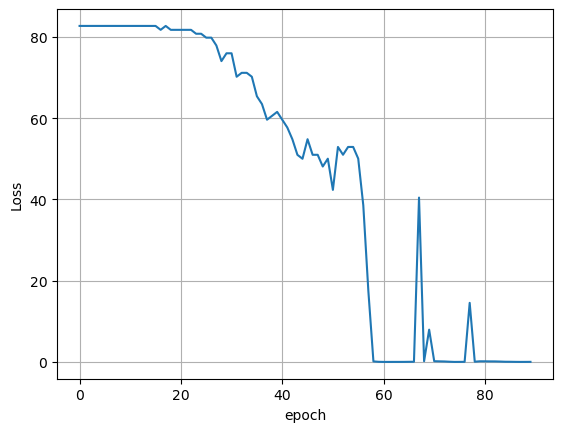

In [ ]:
plt.plot(range(len(cum_loss)), cum_loss)
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.grid('on')
plt.show()

In [ ]:
yini.shape
remainder = remainder.unsqueeze(0)
remainder.shape

torch.Size([1, 4])

In [ ]:
for param in controller.parameters():
    print(param)

Parameter containing:
tensor([717.1511], requires_grad=True)
Parameter containing:
tensor([0.0010], requires_grad=True)
Parameter containing:
tensor([0.0153], requires_grad=True)


In [ ]:
vid_fname = 'cartpole_initial.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}/%03d.png -vcodec libx264 -crf 25 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p {}'.format(
    t_dir, vid_fname
)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

Saving video to: cartpole_initial.mp4


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566267822/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566267822/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-gpl --enable-libx264 --enable